# **Forecasting PM2.5 Concentration on South Jakarta Air**

**Rizal Purnawan**\
ORICD: [0000-0001-8858-4036](https://orcid.org/0000-0001-8858-4036)

In this notebook, we will analyse the time series data of air quality in South Jakarta. We will analyse temporal patterns in the data and we will perform a short period forecast using a machine learning (ML) model.

In [ ]:
#@title ##### Python Libraries in Use

from datetime import datetime
import pytz
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#@title ##### Installing AbstrakTS

# Installing abstrakTS package for time series forecast:
!pip install git+https://github.com/rizalpurnawan23/AbstrakTS.git
from abstrakTS.abstrakTS import AbstrakTS

## **1. Introduction**

Jakarta is the most populated city in Indonesia, and is among top 50 most populated cities in the world. Occurence of various challenging problems is natural with such a circumstance. One of the current issues in Jakarta is the low air quality, which is caused by various factors such as vehical emissions, wheather, etc. Another serious factor is due to the activity of power plants and factories in the surrounding area of Jakarta. Therefore, monitoring the air quality of Jakarta is very important to help take necessary actions, since it is densely inhabited.

In this project, we analyse the an air quality data in South Jakarta. The data is accessed from OpenAQ API. The data is a time series data consiting of timestamp and the concentration of PM2.5 (Particulate Matter with diameter smaller than or equal to 2.5 micormeters). If PM2.5 concentration is high in the air, it could cause respiratory disease since it could penetrate deep into the respiratory system when inhaled due to its small size.

We will also perform a short-perod forecasting on the concentration of PM2.5 using the result of the data analysis using a machine learning (ML) model. This forcast can help mitigate undesirable situation due to air pollutions.

## **2. Data Collection**

The air quality data is obtained from OpenAQ API. The following code will execute the extraction from the source.

In [ ]:
#@title ##### Importing South Jakarta Air Quality Data from OpenAQ

# OpenAQ API:
def access_OpenAQ(
        url= "https://api.openaq.org/v1/measurements",
        utc= False,
        **parameters
        ):
    response = requests.get(url, params= parameters)
    if response.status_code == 200:
        data = response.json()
        loc_time = "utc" if utc == True else "local"
        timestamp = [x["date"][loc_time] for x in data['results']]
        pm25 = [x["value"] for x in data['results']]
        latitude = [x["coordinates"]["latitude"] for x in data['results']]
        longitude = [x["coordinates"]["longitude"] for x in data['results']]
        df = pd.DataFrame(
            {
                "Date": timestamp,
                "pm25": pm25,
                "latitude": latitude,
                "longitude": longitude
                }
        )
        return df
    else:
        # Error Meassage:
        print(f"Error: {response.status_code}, {response.text}")

# Getting current time in Jakarta:
current_time_utc = datetime.utcnow()
jakarta_timezone = pytz.timezone('Asia/Jakarta')
current_time_jakarta = current_time_utc.replace(tzinfo=pytz.utc).astimezone(jakarta_timezone)

time_now_Jakarta = current_time_jakarta.strftime('%Y-%m-%dT%H:%M:%S')

jaksel_params = {
    'location_id': '8320',  # SOUTH JAKARTA
    'parameter': 'pm25',
    'date_from': '2023-12-01',
    'date_to': '2024-01-27',
}

jaksel_pm25 = access_OpenAQ(**jaksel_params)

# Displaying the data:
jaksel_pm25.head(10)

,Date,pm25,latitude,longitude
0,2024-01-27T07:00:00+07:00,15.0,-6.236704,106.793244
1,2024-01-27T06:00:00+07:00,11.0,-6.236704,106.793244
2,2024-01-27T05:00:00+07:00,8.0,-6.236704,106.793244
3,2024-01-27T04:00:00+07:00,17.0,-6.236704,106.793244
4,2024-01-27T03:00:00+07:00,17.0,-6.236704,106.793244
5,2024-01-27T02:00:00+07:00,17.0,-6.236704,106.793244
6,2024-01-27T01:00:00+07:00,12.0,-6.236704,106.793244
7,2024-01-27T00:00:00+07:00,29.0,-6.236704,106.793244
8,2024-01-26T23:00:00+07:00,10.0,-6.236704,106.793244
9,2024-01-26T22:00:00+07:00,13.0,-6.236704,106.793244


Now we will process the data according to our need. We will enumerate the data in a chronological order, from the earliest to the lates. Since our focus study is only South Jakarta, we will filter the data based on only what we require.

In [ ]:
#@title ##### Preprocessing

# Transforming the 'Date' feature into datetime data type:
date_jaksel = pd.to_datetime(jaksel_pm25['Date'])

# Generating a new dataframe:
jaksel_df = pd.DataFrame(
    {"Date": date_jaksel, "pm25": jaksel_pm25["pm25"]}
)

# Reordering the data:
jaksel_df = jaksel_df.sort_values(by= ["Date"], ascending= True)
jaksel_df = jaksel_df.reset_index().drop("index", axis= 1)

# Displaying the result:
print("The first 10 rows of the preprocess data:")
display(jaksel_df.head(10))

print("\nThe last 10 rows of the preprocess data:")
display(jaksel_df.tail(10))
print("\n")

The first 10 rows of the preprocess data:


,Date,pm25
0,2024-01-23 04:00:00+07:00,15.0
1,2024-01-23 05:00:00+07:00,19.0
2,2024-01-23 06:00:00+07:00,20.0
3,2024-01-23 07:00:00+07:00,13.0
4,2024-01-23 08:00:00+07:00,18.0
5,2024-01-23 09:00:00+07:00,14.0
6,2024-01-23 10:00:00+07:00,12.0
7,2024-01-23 11:00:00+07:00,11.0
8,2024-01-23 12:00:00+07:00,14.0
9,2024-01-23 13:00:00+07:00,12.0



The last 10 rows of the preprocess data:


,Date,pm25
90,2024-01-26 22:00:00+07:00,13.0
91,2024-01-26 23:00:00+07:00,10.0
92,2024-01-27 00:00:00+07:00,29.0
93,2024-01-27 01:00:00+07:00,12.0
94,2024-01-27 02:00:00+07:00,17.0
95,2024-01-27 03:00:00+07:00,17.0
96,2024-01-27 04:00:00+07:00,17.0
97,2024-01-27 05:00:00+07:00,8.0
98,2024-01-27 06:00:00+07:00,11.0
99,2024-01-27 07:00:00+07:00,15.0


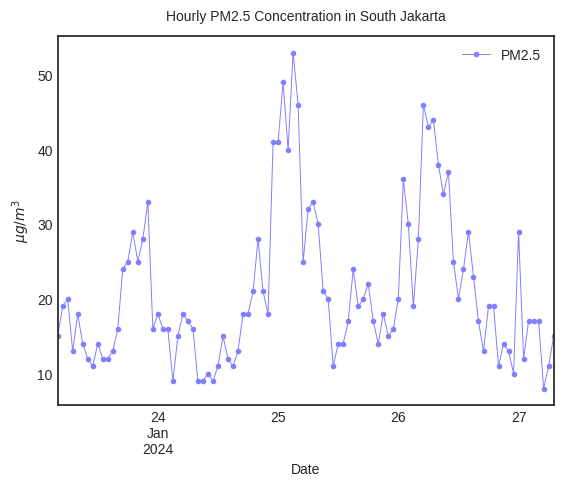

In [ ]:
#@title ##### Visualizing the data:
with mpl.style.context("seaborn-v0_8-white", after_reset= True):
    jaksel_fig = jaksel_df.plot(
        x= "Date", y= "pm25",
        color= plt.cm.cool(0.5), marker= ".", linewidth= 0.7,
        label= "PM2.5", ylabel= r"$\mu g / m^3$"
        )
    jaksel_fig = plt.title(
        "Hourly PM2.5 Concentration in South Jakarta",
        fontsize= 10,
        pad= 11
    )
    jaksel_fig = plt.show()

## **3. Time Series Analysis**

Our goal in this project is building a time series model for a short period forecasting the concentration of PM2.5 in the air of South Jakarta. In this section, we will build the mathematical framework for the time series model and perform statistical analysis to find relations and generate more features for the moodel.

### **3.1. Mathematical Framework of Time Series**

In the preprocessed dataset of air quality, we have two features, namely the `Date` feature and `pm25` feature containting the concentration data of PM2.5 in $\mu g/m^3$. The `Date` feature is unique, meaning that there are distinct number of `Date` elements as many as the number of datapoints in the dataset. With this property, we can identify the data as `Date`, and hence, we designate `Date` as a sample space $\Omega$. The elements in our initial data of `Date` is considered to be a subset of $\Omega$ instead of the $\Omega$ itself. We take into account the `Date` values in the forecasting as elements of $\Omega$ as well.

#### **3.1.1. Probability Theoretic Model**

Now we build a probability space $(\Omega, \mathcal{F}, P)$ on $\Omega$ where $\mathcal{F}$ is an event space (a $\sigma$-algebra on $\Omega$) and $P: \mathcal{F} \to [0, 1]$ is a probability measure on $\mathcal{F}$. Then we designate feature `pm25` as a random variable $Y: \Omega \to \mathbb{R}$. Note that our data as a whole is discrete and finite. And the values of `pm25` is bounded, meaning that
$$
    \forall \omega \in \Omega :\; |Y(\omega)| < \infty \,.
$$
This circumstances guarantee that $Y \in L^2(P)$.

In our approach, we will assume that $Y: \Omega \to \mathbb{R}$ is a linear combination of other $L^2$ random variables. In general, let $n \in \mathbb{N}$ such that $Y_1, \dotsc, Y_n, \varepsilon \in L^2(P)$ are the random variables and
$$
    \forall \omega \in \Omega :\;
    Y(\omega) = \left( \sum_{k = 1}^n Y_k(\omega) \right) + \varepsilon(\omega)
    \,.
$$
This formulation is still free of interpretation. We still not assume any $Y_k$ representing any time series component, while there could be one. Our approximated model for $Y: \Omega \to \mathbb{R}$ will be a random variable $\hat{Y} \in L^2(P)$ defined by
$$
    \forall \omega \in \Omega :\;
    \hat{Y}(\omega) := \sum_{k = 1}^n Y_k(\omega) \,.
$$
Hence, $\varepsilon = Y - \hat{Y}: \Omega \to \mathbb{R}$ is an error estimate.

It is desired that $Y_n: \Omega \to \mathbb{R}$ is stationary, meaning that it generates no more trends. A perfect stationarity would be difficult to obtain. However, a weak stationarity is considered to be enough. Random variable $Y_n: \Omega \to \mathbb{R}$ is weak stationary if there exists some small $\delta > 0$ such that
$$
    \forall \omega \in \Omega :\;
    \mathrm{Mstd}_{Y_n}(\omega) \in B^{\mathbb{R}}_\delta( \mathrm{std}(Y_n) ) \,,
$$
where $\mathrm{Mstd}_{Y_n}: \Omega \to \mathbb{R}$ is the moving standard deviation of $Y_n$ defined by conditional standard deviation
$$
    \forall \omega \in \Omega :\;
    \mathrm{Mstd}_{Y_n}(\omega)
    := \mathrm{std}\big( Y_n \mid B^{\Omega}_r(\omega) \big)
    \,,
$$
$B^{\Omega}_r: \Omega \to \mathcal{T}_{\Omega} \subseteq \mathcal{F}$ is an open ball operator of radius $r > 0$ on a topological space $(\Omega, \mathcal{T}_{\Omega})$, $\mathrm{std}: L^2(P) \to \mathbb{R}$ is the standard deviation operator, and $B^{\mathbb{R}}_\delta: \mathbb{R} \to \mathcal{T}_{\mathbb{R}}$ is an open ball operator of radius $\delta$ on the standard topological space $(\mathbb{R}, \mathcal{T}_{\mathbb{R}})$. In this case, $Y_n$ may be referred to as of $\delta$-weak stationary.

On the next subsections, we will perform statistical analyses to find relations on our data and generate more features to help build $Y_1, \dotsc, Y_n$ for the time series model.

#### **3.1.2. Finding Stationary Component**

In this section, we will perform a statistical analysis to find $Y_n$. The indicator is that $Y_n$ shall be $\delta$-weak stationary. The decomposition method that we employ in this case is differencing the original data from its moving average. In general, for any random variable $Z: \Omega \to \mathbb{R}$, the moving average of $Z$ is a map $\mathrm{MA}_Z: \Omega \to \mathbb{R}$ defined by the conditional expectation
$$
    \forall \omega \in \Omega :\;
    \mathrm{MA}_Z(\omega) := \mathrm{E}[ Z \mid B^{\Omega}_w(\omega) ] \,,
$$
where $B^{\Omega}_w: \Omega \to \mathcal{T}_{\Omega} \subseteq \mathcal{F}$ is an open ball operator of radius $w > 0$ on a topological space $(\Omega, \mathcal{T}_{\Omega})$. In this case, we assume that $(\Omega, \mathcal{F})$ is a Borel measurable space and $\mathcal{F}$ is a Borel $\sigma$-algebra.

For an efficient approach, it is naturally desirable that $n$ could be as small as possible. The structure of our time series should include the major trend of the time series. Hence, we define $Y_1: \Omega \to \mathbb{R}$ to be the major trend. It will be determined as the moving average $\mathrm{MA}_Y: \Omega \to \mathbb{R}$ of $Y$. We may use a considerable large $w > 0$ for $\mathrm{MA}_Y$ such that it is relatively linear. Then we define $Y_3: \Omega \to \mathbb{R}$ by
$$
    \forall \omega \in \Omega :\;
    Y_3(\omega)
    := Y_1(\omega) - Y_2(\omega)
    := Y_1(\omega) - \mathrm{MA}_{Y_1}(\omega) \,.
$$
We wish $Y_3$ had already been stationary. Therefore, we will observe the possible stationarity of $Y_3$. We will need to find the an optimum $w > 0$ such that we obtain a considerably small $\delta$ and if possible we could have a $\delta$-weak stationary $Y_3$.

We will use the module `AbstrakTS` for computing necessary properties in time series analysis. The computation of the $\delta$-weak stationarity of $Y_3$ is conducted in the following cell:

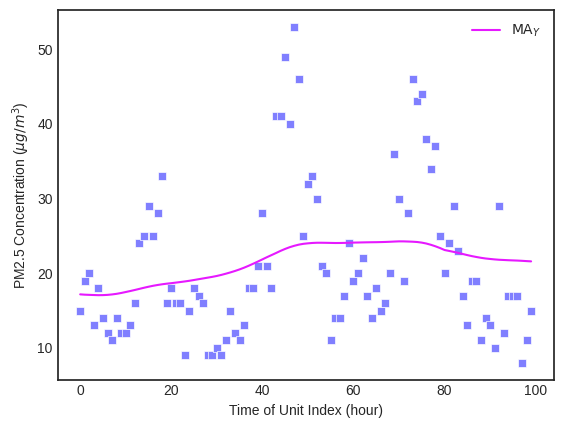

In [ ]:
#@title ##### Computing $Y_1$

# Instantiating AbstrakTS:
ats = AbstrakTS()

# Generating a copy of original data:
ts_decompos = jaksel_df.copy()

# First w:
w_first = 20    # <-- CHANGE VALUE FOR REFINEMENT

# Analysing major trend from regplot:
with mpl.style.context("seaborn-v0_8-white", after_reset= True):
    # maj_trend_fig, maj_trend_axs = plt.subplots(
    #     nrows= 1, ncols= 2, figsize= (12, 4)
    #     )
    # maj_trend_fig = sns.regplot(
    #     x= ts_decompos.index, y= ts_decompos["pm25"],
    #     marker= "s", color= plt.cm.cool(0.5),
    #     ax = maj_trend_axs[0]
    #     )
    # maj_trend_fig = sns.scatterplot(
    #     x= ts_decompos.index, y=ts_decompos["pm25"],
    #     marker= "s", color= plt.cm.cool(0.5),
    #     ax= maj_trend_axs[1]
    # )
    # maj_trend_axs[0].set(
    #     xlabel= "Time of Unit Index (hour)",
    #     ylabel= r"PM2.5 Concentration ($\mu g /m^3$)"
    #     )

    # maj_trend_axs[1].plot(
    #     ts_decompos.index,
    #     ats.moving_average(
    #         ats.moving_average(
    #             ts_decompos["pm25"],
    #             w_first
    #             ),
    #         w_first
    #     ),
    #     label= r"$\mathrm{MA}_{Y}$",
    #     color= plt.cm.cool(0.9)
    # )
    # maj_trend_axs[1].legend()
    # maj_trend_axs[1].set(
    #     xlabel= "Time of Unit Index (hour)",
    #     ylabel= r"PM2.5 Concentration ($\mu g /m^3$)"
    # )
    # maj_trend_fig = plt.show()
    maj_trend_fig = plt.figure()
    maj_trend_fig = sns.scatterplot(
        x= ts_decompos.index, y=ts_decompos["pm25"],
        marker= "s", color= plt.cm.cool(0.5)
    )
    maj_trend_fig = plt.plot(
        ts_decompos.index,
        ats.moving_average(
            ats.moving_average(
                ts_decompos["pm25"],
                w_first
                ),
            w_first
        ),
        label= r"$\mathrm{MA}_{Y}$",
        color= plt.cm.cool(0.9)
    )
    maj_trend_fig = plt.legend()
    maj_trend_fig = plt.xlabel("Time of Unit Index (hour)")
    maj_trend_fig = plt.ylabel(r"PM2.5 Concentration ($\mu g /m^3$)")
    maj_trend_fig = plt.show()


# maj_trend_fig = plt.figure()
# maj_trend_fig = sns.regplot(
#     x= ts_decompos.index, y= ts_decompos["pm25"],
#     marker= "^", color= plt.cm.cool(0.5)
#     )
# maj_trend_fig = plt.xlabel("Time of Unit Index (hour)")
# maj_trend_fig = plt.ylabel(r"PM2.5 Concentration ($\mu g /m^3$)")
# maj_trend_fig = plt.show()

<!-- The computation above shows that the major trend is a flat lienar trend. We will take this result and designate that $Y_1$ is a constant and is defined by
$$
    \forall \omega \in \Omega :\;
    Y_1(\omega) := \mathrm{E}[Y] = \int_\Omega Y \,\mathrm{d}P \,.
$$
Note that $\mathrm{E}: L^1(P) \to \mathbb{R}$ is the expectation operator. Now we proceed for computing the optimized $w$ for $Y_2$ such that $Y_3$ is $\delta$-weak stationary. -->
The trend on the right side figure is generated by applying moving average to the moving averge of $Y: \Omega \to \mathbb{R}$. So it is infact $\mathrm{MA}_{\mathrm{MA}_Y}$ instead of $\mathrm{MA}_Y \,.$ But, we will stick to this method.

Optimized w = 5
Corresponding delta = 0.488




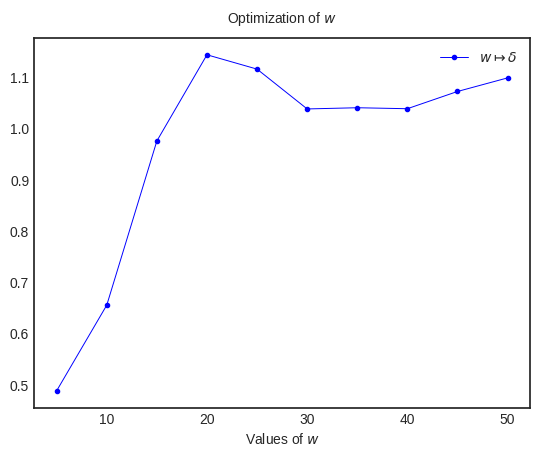

In [ ]:
#@title ##### Optimization on $w$

# Computing Y1:
ts_decompos["Y1"] = ats.moving_average(
    ats.moving_average(ts_decompos["pm25"], w_first),
    w_first
    )

# Computing Y2:
# Function for determining an optimum w:
def optimize_w(Y, w_list, r= 30, complete_output= False):
    delta_list = list()
    for w in w_list:
        ma = ats.moving_average(Y, w)
        Y_dec = np.array(Y) - np.array(ma)
        std = np.std(Y_dec)
        mstd = ats.moving_std(Y_dec, r)
        delta = max([abs(x - std) for x in mstd])
        delta_list.append(delta)
    delta_w = dict(zip(delta_list, w_list))
    w = delta_w[min(delta_list)]
    if complete_output == False:
        return w, min(delta_list)
    else:
        delta_w_df = pd.DataFrame({"w": w_list, "delta": delta_list})
        return delta_w_df

# r_std = 50      # <-- Adjust this value
def find_best_r_std():
    r_std_list = list(range(5, int(0.7 *len(ts_decompos))))
    delta_list = list()
    for r in r_std_list:
        _, delta = optimize_w(
            ts_decompos["pm25"] - ts_decompos["Y1"],
            [5 *k for k in range(1, 11)],   # <-- possible values of w
            complete_output= False, r= r
        )
        delta_list.append(delta)
    delta_r = dict(zip(delta_list, r_std_list))
    r_std = delta_r[min(delta_list)]
    return r_std

r_std = find_best_r_std()

Y3_delta_weak_stat = optimize_w(
    ts_decompos["pm25"] - ts_decompos["Y1"],
    [5 *k for k in range(1, 11)],   # <-- possible values of w
    complete_output= True, r= r_std
)

# Displaying the most optimum w:
opt_w_del = optimize_w(
    ts_decompos["pm25"] - ts_decompos["Y1"],
    [5 *k for k in range(1, 11)],   # <-- possible values of w
    r= r_std,
)

print(f"Optimized w = {opt_w_del[0]}")
print(f"Corresponding delta = {round(opt_w_del[1], 3)}")
print("\n")

# Optimization graph of w and delta:
with mpl.style.context("seaborn-v0_8-white", after_reset= True):
    opt_delta_fig = Y3_delta_weak_stat.plot(
        x= "w", y= "delta",
        color= "blue", marker= ".",
        xlabel= r"Values of $w$",
        linewidth= 0.7, label= r"$w \mapsto \delta$"
    )
    opt_delta_fig = plt.title(r"Optimization of $w$", fontsize= 10, pad= 11)
    opt_delta_fig = plt.show()

We will use $w$ and the corresponding $\delta$ from the computation above.

The decomposition of $Y$ is then given by
$$
    \forall \omega \in \Omega :\;
    Y(\omega)
    = \left( \sum_{k = 1}^3 Y_k(\omega) \right) + \varepsilon(\omega)
$$
where $Y_1, Y_2, Y_3$ are approximated as
\begin{align*}
    %Y_1 &\approx \mathrm{E}[Y] \\
    %Y_2 &\approx \mathrm{MA}_{Y - \mathrm{E}[Y]} \\
    %Y_3 &\approx Y - \mathrm{E}[Y] -\mathrm{MA}_{Y - \mathrm{E}[Y]}
    Y_1 &\approx \mathrm{MA}_{\mathrm{MA}_Y} \\
    Y_2 &\approx \mathrm{MA}_{Y - \mathrm{MA}_{\mathrm{MA}_Y}} \\
    Y_3 &\approx Y - \mathrm{MA}_{\mathrm{MA}_Y}
    -\mathrm{MA}_{Y - \mathrm{MA}_{\mathrm{MA}_Y}}
\end{align*}
and
$$
    \varepsilon = Y - \sum_{k = 1}^n Y_k \,.
$$


The illustration of the decomposition of $Y$ is presented in the figure below.

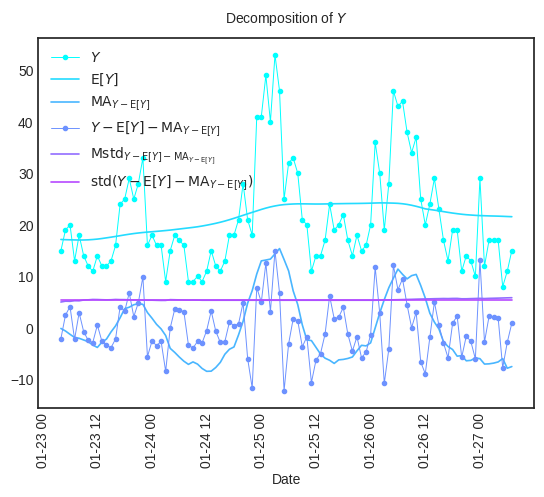

In [ ]:
#@title ##### Decomposition of $Y$

# Genearing the approximate Y2:
ts_decompos["appx_Y2"] = ats.moving_average(
    ts_decompos["pm25"] - ts_decompos["Y1"],
    opt_w_del[0]
)

# Generating the approximate Y3:
ts_decompos["appx_Y3"] = ts_decompos["pm25"] \
    - ts_decompos["Y1"] - ts_decompos["appx_Y2"]

# Generating Mstd_Y3:
ts_decompos["ms_appx_Y3"] = ats.moving_std(ts_decompos["appx_Y3"], r_std)

# Generating std_Y1:
ts_decompos["std_appx_Y3"] = np.std(list(ts_decompos["appx_Y3"]))

# Visualizing the result:
def alt_fig(
        df, index_col,
        labels= None, markers= None,
        cmap= plt.cm.cool, linewidths= None,
        style= "default", figsize= None, rots= None,
        title= "Alternative Figure", legend_loc= "upper left",
        tit_fs= 10, tit_pad= 11
        ):
    with mpl.style.context(style, after_reset= True):
        fig = plt.figure(figsize= figsize)
        plotted_cols = [c for c in df.columns if c != index_col]
        N = len(plotted_cols)
        if markers is None:
            markers = [None] *N
        if labels is None:
            labels = [None] *N
        if linewidths is None:
            linewidths = [1] *N
        for col, k in zip(plotted_cols, range(N)):
            fig = plt.plot(
                df[index_col], df[col],
                marker= markers[k],
                label= labels[k],
                color= cmap(k / (N + 1)),
                linewidth= linewidths[k]
                )
            if rots is not None:
                fig = plt.xticks(rotation= rots[k])
        if all(l is not None for l in labels):
            fig = plt.legend(loc= legend_loc)
        fig = plt.xlabel(index_col)
        fig = plt.title(title, fontsize= tit_fs, pad= tit_pad)
        fig = plt.show()

alt_fig(
    ts_decompos, "Date",
    labels= [
        r"$Y$",
        r"$\mathrm{E}[Y]$",
        r"$\mathrm{MA}_{Y - \mathrm{E}[Y]}$",
        r"$Y -\mathrm{E}[Y] -\mathrm{MA}_{Y - \mathrm{E}[Y]}$",
        r"$\mathrm{Mstd}_{Y -\mathrm{E}[Y] -\mathrm{MA}_{Y - \mathrm{E}[Y]}}$",
        r"$\mathrm{std}(Y -\mathrm{E}[Y] -\mathrm{MA}_{Y - \mathrm{E}[Y]})$"
        ],
    rots= [90] *6,
    markers= [".", None, None, ".", None, None],
    linewidths= [0.7, 1.2, 1.2, 0.7, 1.2, 1.2],
    title= r"Decomposition of $Y$",
    style= "seaborn-v0_8-white"
    )

### **3.2. Statistical and Feature Analyses**

Now let us observe more relations in the dataset such that we may generate more features which would be necessary in building the time series model.

#### **3.2.1. Day Feature**

For a starter, it is worth investigating whether there is a linear relationship between days and $Y_1$, $Y_2$ as well as $Y_3$. At the next subsection, we will investigat the linear relationship between hours and $Y_1$, $Y_2$ as well as $Y_3$.

First, we need to generate a random variable representing the recording days. Let $X_d: \Omega \to \mathbb{R}$ be the random variable. Note that
$$
    \mathrm{image}(X_d) \subset \{1, \dotsc, 31\} \,.
$$
Also, since $|\Omega| < \infty$, it can be guaranteed that $X_d \in L^2(P)$. Now let us observe the Pearson correlation of $X_d$ with $Y_2$, and $X_h$ with $Y_3$. Pearson correlation is well defined on the family of $L^2(P)$ random variables which are not almost surely constants. Let
$$
    \mathcal{V} := \{X \in L^2(P) \mid \forall x \in \mathbb{R}[P(X = x) < 1]\}
$$
be the family. Pearson correlation is given as a map $\mathrm{corr}: \mathcal{V} \times \mathcal{V} \to [-1, 1]$ defined by
$$
    \forall U, V \in \mathcal{V} :\;
    \mathrm{corr}(U, V)
    := \frac{\mathrm{cov}(U, V)}{\mathrm{std}(U) \cdot \mathrm{std}(V)}
$$
where $\mathrm{cov}: L^2(P) \times L^2(P) \to \mathbb{R}$ is covariance and $\mathrm{std}: L^2(P) \to \mathbb{R}$ is standard deviation.

Also, if we observe the graph earlier, it intuitively suggests that there is some kind of relationship between half of day and $Y_2$ as well as $Y_3$. We will try to capture this hypothesis more formally. However, as the data in `Date` is in date-time format, it is not possible to capture the half of a day into a numeric data using the `date` method. Instead, we employ modulo arithmetic to capture this point.

And let $\iota: \Omega \to I$ be a injective map representing the index of the dataset. That is $\iota(\omega)$ is the index of $\omega \in \Omega$ in according to the original enumeration of the dataset. The random variable representing the half of day feature is given by a map $X_{hd}: \Omega \to \mathbb{R}$ defined by
$$
    \forall \omega \in \Omega :\;
    X_{hd}(\omega) :=
    \left\lfloor \frac{\iota(\omega)}{6} \right\rfloor \,.
$$
Note that the `pm25` is recorded hourly, hence the divisor in the expression above is 6.

The computations of the correlations are conducted in the following cell:

In [ ]:
#@title ##### Computing correlations of $X_d$ with $Y_2$ and $X_d$ with $Y_3$

# Generating a new dataset for statistical analysis:
sa_df = pd.DataFrame(
    ts_decompos,
    columns= [
        "Date", "pm25", "Y1", "appx_Y2", "appx_Y3"
        ]
    )

# Generating the hour feature:
sa_df["day"] = [int(str(d.date())[-2:]) for d in sa_df["Date"]]

# Generating the half-day feature:
sa_df["half_day"] = [divmod(i, 6)[0] for i in sa_df.index]

# Note:
# The correlation will only be computed on the training dataset.
# The validation set consists of 24 datapoints.

# Correlations of Day Feature:
# Correlation of Xh and Y1:
corr_Xd_Y1 = ats.corr(
    list(sa_df["day"])[:-24],
    list(sa_df["Y1"])[:-24]
    )

# Correlation of Xh and Y2:
corr_Xd_Y2 = ats.corr(
    list(sa_df["day"])[:-24],
    list(sa_df["appx_Y2"])[:-24]
    )

# Correlation of Xh and Y3:
corr_Xd_Y3 = ats.corr(
    list(sa_df["day"])[:-24],
    list(sa_df["appx_Y3"])[:-24]
    )

# Presentation:
print("Correlations of Day Feature")
print("-" *len("Correlations of Day Feature"))

print(f"corr(Xd, Y1) = {round(corr_Xd_Y1, 3)}")
print(f"corr(Xd, Y2) = {round(corr_Xd_Y2, 3)}")
print(f"corr(Xd, Y3) = {round(corr_Xd_Y3, 3)}")

# Correlations of Half-Day Feature:
# Correlation of Xh and Y1:
corr_Xd_Y1 = ats.corr(
    list(sa_df["half_day"])[:-24],
    list(sa_df["Y1"])[:-24]
    )

# Correlation of Xh and Y2:
corr_Xd_Y2 = ats.corr(
    list(sa_df["half_day"])[:-24],
    list(sa_df["appx_Y2"])[:-24]
    )

# Correlation of Xh and Y3:
corr_Xd_Y3 = ats.corr(
    list(sa_df["half_day"])[:-24],
    list(sa_df["appx_Y3"])[:-24]
    )

# Presentation:
print("\nCorrelations of Half-Day Feature")
print("-" *len("Correlations of Half-Day Feature"))

print(f"corr(Xd, Y1) = {round(corr_Xd_Y1, 3)}")
print(f"corr(Xd, Y2) = {round(corr_Xd_Y2, 3)}")
print(f"corr(Xd, Y3) = {round(corr_Xd_Y3, 3)}")

# Intercorrelation of Half-Day and Day Features:
print("\nCorrelation of Half-Day and Day Features")
print("-" *len("Correlation of Half-Day and Day Features"))
print(
    "corr(X_hd, X_d) = ",
    round(
        ats.corr(
            list(sa_df["half_day"])[:-24],
            list(sa_df["day"])[:-24]
            ),
        3
    )
)

Correlations of Day Feature
---------------------------
corr(Xd, Y1) = 0.926
corr(Xd, Y2) = 0.256
corr(Xd, Y3) = 0.089

Correlations of Half-Day Feature
--------------------------------
corr(Xd, Y1) = 0.965
corr(Xd, Y2) = 0.184
corr(Xd, Y3) = 0.052

Correlation of Half-Day and Day Features
----------------------------------------
corr(X_hd, X_d) =  0.951


#### **3.2.1. Hours Feature**

Note that, the timestamp of our dataset is dates with hours. In fact, the records of PM2.5 concentration were done hourly. As we look at the graph of the decomposition, it suggests an existence of periodic pattern on $Y_2$ and $Y_3$. Therefore, it is worth investigating additional feature is the hour feature, since our data is recorded hourly. We will observe the correlation of the hour feature and $Y_2$ as well as the hour feature and $Y_3$.

First, we need to generate a random variable representing the recording hours. Let $X_h: \Omega \to \mathbb{R}$ be the random variable. Note that
$$
    \mathrm{image}(X_h) \subset \{0, 1, \dotsc, 23\} \,.
$$
Also, since $|\Omega| < \infty$, it can be guaranteed that $X_h \in L^2(P)$. Now let us observe the Pearson correlation of $X_h$ with $Y_2$, and $X_h$ with $Y_3$.

The computation of correlations is conducted in the following cell:

In [ ]:
#@title ##### Computing correlations of $X_h$ with $Y_2$ and $X_h$ with $Y_3$

# Generating the hour feature:
sa_df["hour"] = [int(str(d.time())[:2]) for d in sa_df["Date"]]

# The correlation will only be computed on the training dataset.
# The validation set consists of 24 datapoints.

# Correlation of Xh and Y2:
corr_Xh_Y2 = ats.corr(
    list(sa_df["hour"])[:-24],
    list(sa_df["appx_Y2"])[:-24]
    )

# Correlation of Xh and Y3:
corr_Xh_Y3 = ats.corr(
    list(sa_df["hour"])[:-24],
    list(sa_df["appx_Y3"])[:-24]
    )

# Presentation:
print("Correlations")
print("-" *len("Correlations"))

print(f"corr(Xh, Y2) = {round(corr_Xh_Y2, 3)}")
print(f"corr(Xh, Y3) = {round(corr_Xh_Y3, 3)}")

Correlations
------------
corr(Xh, Y2) = -0.281
corr(Xh, Y3) = -0.127


There are quite significant correlations for $X_h$ and $Y_2$ as well as $X_h$ and $Y_3$.

#### **3.2.2. Modulo Features**

It may not clearly be descriptive about the real world activities related to pollutions. For instance, if the major cause of the pollution is the vehicle emissions, then the repetition should be around 10 to 15 hours since the traffic is dense in the morning and in the evening. Therefore, it is worth investigating about other random variables which can represent this relationship.

We will construct other random variables but in a more general approach. Let $X: \Omega \to \mathbb{R}$ be another random variable such that $X(\omega) \in \mathbb{N}$ is the order of an element $\omega \in \Omega$ according to the time ordering. Note that $X \in L^2(P)$ since we only have finite datapoints, hence
$$
    \forall \omega \in \Omega :\; |X(\omega)| = X(\omega) < \infty \,.
$$

Let $m \in \mathbb{N}$ such that $1 < m < 24$. One of the additional features that we are about to construct is a random variable $X_m: \Omega \to \mathbb{R}$ defined by
$$
    \forall \omega \in \Omega :\;
    X_m(\omega) := X(\omega) - \left\lfloor \frac{X(\omega)}{m} \right\rfloor m \,.
$$
Numbers such as $m$ with respect to the expression above may be referred to as divisors and the corresponding random variables is referred to as modulo random variables. We will seek for divisors $m_1, m_2, \dotsc, m_j \in \mathbb{N}$ such as $m$ such that random variables $X_{m_1}, \dotsc, X_{m_j}: \Omega \to \mathbb{R}$ defined similar to $X_m$ have considerable Pearson correlation with both $Y_2$ and $Y_3$.

In particular, we will pick random variables with $|\mathrm{corr}(X_m, Y_2)|$ and $|\mathrm{corr}(X_m, Y_3)|$ greater than or equal to 0.15. The computation is conducted in the following cell:

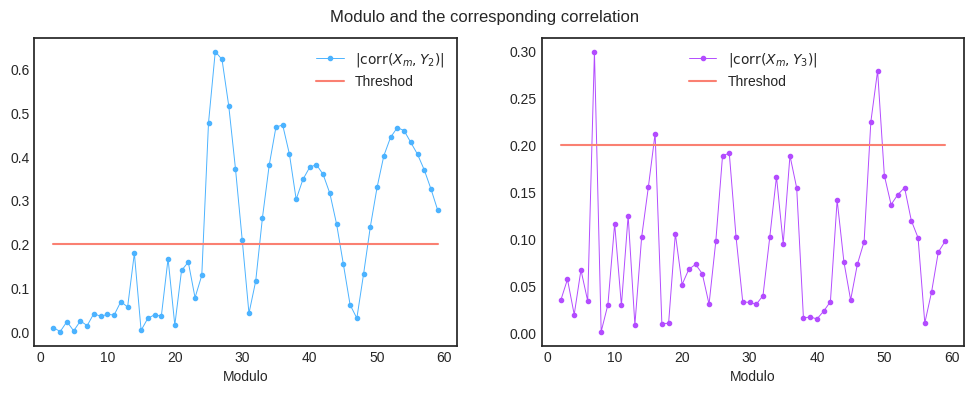

In [ ]:
#@title ##### Finding additional features:
def modulo_features(mods, Y, absolute= False):
    corr_list = list()
    for m in mods:
        # Xm = [x % m for x in sa_df.index]
        Xm = [x % m for x in sa_df.index[:-24]]
        corr_list.append(ats.corr(Xm, Y))
    df = pd.DataFrame({"mod": mods, "corr": corr_list})
    if absolute == True:
        df["corr"] = df["corr"].abs()
    return df

# The correlation will only be computed on the training dataset.
# The validation set consists of 24 datapoints.

# Related to Y2:
mod_corr_Y2 = modulo_features(
    range(2, int(2.5 *24)),
    list(sa_df["appx_Y2"])[:-24],
    absolute= True
)

# Related to Y3:
mod_corr_Y3 = modulo_features(
    range(2, int(2.5 *24)),
    list(sa_df["appx_Y3"])[:-24],
    absolute= True
)

modulo_threshold = 0.2

# Presenting the result:
with mpl.style.context("seaborn-v0_8-white", after_reset= True):
    mod_feat_fig, mod_feat_axs = plt.subplots(
        nrows= 1, ncols= 2, figsize= (12, 4)
    )
    mod_feat_fig = mod_corr_Y2.plot(
        x= "mod", y= "corr",
        xlabel= "Modulo", label= r"$|\mathrm{corr}(X_m, Y_2)|$",
        linewidth= 0.7, marker= ".", color= plt.cm.cool(0.3),
        ax= mod_feat_axs[0]
    )
    mod_feat_fig = mod_corr_Y3.plot(
        x= "mod", y= "corr",
        xlabel= "Modulo", label= r"$|\mathrm{corr}(X_m, Y_3)|$",
        linewidth= 0.7, marker= ".", color= plt.cm.cool(0.7),
        ax= mod_feat_axs[1]
    )
    mod_feat_axs[0].plot(
        mod_corr_Y2["mod"], [modulo_threshold] *len(mod_corr_Y2),
        color= "salmon", label= "Threshod"
    )
    mod_feat_axs[0].legend()
    mod_feat_axs[1].plot(
        mod_corr_Y3["mod"], [modulo_threshold] *len(mod_corr_Y3),
        color= "salmon", label= "Threshod"
    )
    mod_feat_axs[1].legend()
    mod_feat_fig = plt.suptitle(
        "Modulo and the corresponding correlation",
        y= 0.95
        )
    mod_feat_fig = plt.show()

#### **3.2.3. Lag Features**

Another type of features worth investigating is the lag features. Let us first present the formal definition of lag features.

For this discussion, we will alternatively express the vector space $L^2(P)$ in a more complete notation as $L^2(\Omega, \mathcal{F}, P)$. Note that our sample space is finite. Alternatively, we can express the sample space as
$$
    \Omega = \{\omega_k\}_{k = 1}^{|\Omega|} \,.
$$
Now suppose a general random variable $W \in L^2(\Omega, \mathcal{F}, P)$. Let $K \in \mathbb{N}$ such that $K < |\Omega|$. A lag feature opearator of lag $K$ is a map $\kappa_K: L^2(\Omega, \mathcal{F}, P) \to L^2(\Omega_K, \mathcal{F}_K, P_K)$ where
$$
    \Omega_K := \{\omega_k\}_{k = K}^{|\Omega|} \,,
$$
$\mathcal{F}_K \subset \mathcal{F}$ is a $\sigma$-algebra on $\Omega_K$ and $P_K: \mathcal{F}_K \to [0, 1]$ is a probability space on $(\Omega_K, \mathcal{F}_K)$. If we apply operator $\kappa_K$ on $W$, we obtain
$$
    \forall k \in \{K, K + 1, \dotsc, |\Omega|\} :\;
    \kappa_K(W)(\omega_k) := W(\omega_{k - K}) \,.
$$

We will observe the proper numbers such as $K$ such that we obtain $\kappa_K(Y_1)$, $\kappa_K(Y_2)$ and $\kappa_K(Y_3)$ which have considerable correlations with $Y_1 |_{\Omega_K}$, $Y_2 |_{\Omega_K}$ and $Y_3 |_{\Omega_K}$ respectively. For a single random variable, we may actually apply more than one lags. Such lags shall have proper partial autocorrelations.

Let us recall the general random variable $W: \Omega \to \mathbb{R}$. For some $M \in \mathbb{N}$ such that $K < M$, partial autocorrelation function of $\kappa_K(W)$ with $\kappa_M(W)$ is given by
$$
    \mathrm{PACF}(\kappa_K(W), \kappa_M(W))
    := \mathrm{corr}\big(
        \kappa_K(W) - \hat{\kappa}_K(W),\,
        \kappa_M(W) - \hat{\kappa}_M(W)
        \big)
$$
by assuming that $\kappa_K(W), \hat{\kappa}_K(W), \kappa_M(W), \hat{\kappa}_M(W): \Omega_M \to \mathbb{R}$, where
$$
    \forall \omega \in \Omega_M :\;
    \hat{\kappa}_K(W)(\omega)
    := \sum_{i = K + 1}^{M - 1} \alpha_i \kappa_i(W)(\omega)
$$
and
$$
    \forall \omega \in \Omega_M :\;
    \hat{\kappa}_M(W)(\omega)
    := \sum_{i = K + 1}^{M - 1} \beta_i \kappa_i(W)(\omega)
$$
for some $\{\alpha_i\}_{i = k + 1}^{M - 1}, \{\beta_i\}_{i = k + 1}^{M - 1} \subset \mathbb{R}$.

Using `AbstrakTS`, we can use an algorthm `pacf_fig` or `pacf_multi_fig` within it to visually observe the partial autocorrelation function (PACF). We will apply the computation to random variables $Y_1$, $Y_2$ and $Y_3$ which are conducted in the following cell:

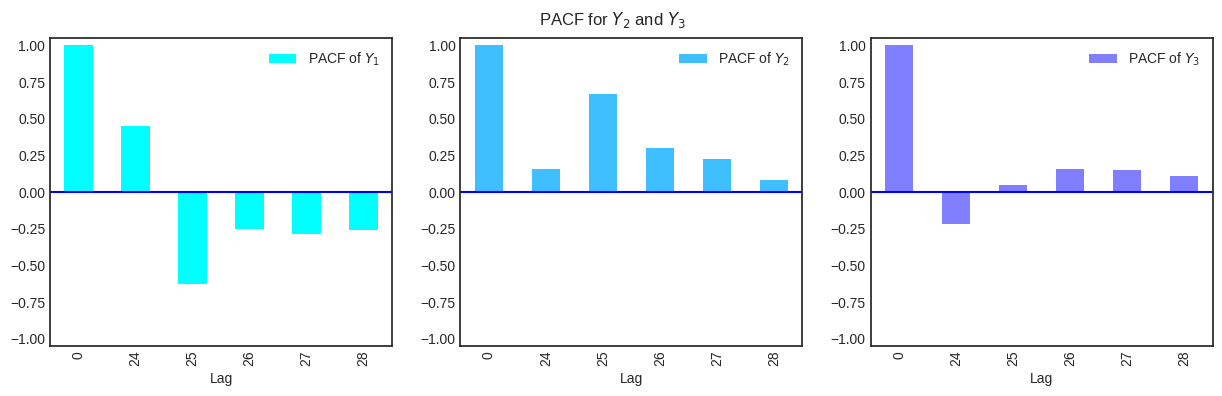

In [ ]:
#@title ##### Lag Features Analysis

# Observing lag features PACF for Y2:
with mpl.style.context("seaborn-v0_8-white", after_reset= True):
    ats.pacf_multi_fig(
        [sa_df["Y1"], sa_df["appx_Y2"], sa_df["appx_Y3"]],
        [24, 24, 24], [5, 5, 5],
        data_id= [r"$Y_1$", r"$Y_2$", r"$Y_3$"],
        title= r"PACF for $Y_2$ and $Y_3$",
        title_y= 0.95, figsize= (15, 4)
    )

From the PACF figure above, we can see that $Y_1$ has a significan PACF on lags 24 and 25, while $Y_2$ on lags 25 and $Y_3$ does not seem to have significant lags. Note that we cannot use larger lags, since it will reduce the quantity of the training data.

## **4. Machine Learning Forecasting Model**

With the result from the time series mathematical model as well as the statistical analysis for relations and features, we now build the forecasting model using ML algiorithm. We will use ML model to predict $Y_1$, $Y_2$ and $Y_3$.

Let us present the framework of the algorithm in a robust and general manner. Let $Y_c \in \{Y_1, Y_2, Y_3\}$, that is $Y_c: \Omega \to \mathbb{R}$ represents $Y_1, Y_2, Y_3$ sequentially. Suppose $\mathcal{X} \subset L^2(P)$ is the family of features which will be used to model $Y_c$, those that we have statistically analysed earlier such as day, half-day, modulo and lag features. A machine learning model for $Y_c$ is a map $\mathrm{ML}: \mathbb{R}^{|\mathcal{X}|} \to \mathbb{R}$ such that
$$
    Y_c = \mathrm{ML} \,\circ\, (X)_{X \in \mathcal{X}}
    : \Omega \to \mathbb{R} \,.
$$

The preparation for training and validation data for the ML models is conducted in the following cell:

In [ ]:
#@title ##### Training and Validation Data

# Algorithm for generating training and validation dataset:
def train_valid_set(
        target, day= False, half_day= False, hour= False,
        modulo= False, lags= None
        ):
    cols = list(sa_df.columns)
    for k, y in zip([2, 3, 4], ["Y1", "Y2", "Y3"]):
        cols[k] = y
    df = sa_df.copy()
    df.columns = cols
    col_drop = [y for y in ["Date", "pm25", "Y1", "Y2", "Y3"] if y != target]
    df.drop(columns= col_drop, inplace= True)

    if day == False:
        df.drop("day", axis= 1, inplace= True)
    if half_day == False:
        df.drop("half_day", axis= 1, inplace= True)
    if hour == False:
        df.drop("hour", axis= 1, inplace= True)

    if target in ["Y2", "Y3"] and modulo == True:
        mod_corr = mod_corr_Y2.copy() if target == "Y2" else mod_corr_Y3.copy()
        thres = modulo_threshold
        if len(mod_corr[(mod_corr["corr"] >= thres)]) > 0:
            corr_mod_dict = dict(
                zip(
                    list(mod_corr["corr"]),
                    list(mod_corr["mod"])
                    )
                )
            for c in corr_mod_dict.keys():
                if c >= thres:
                    m = corr_mod_dict[c]
                    df[f"X{m}"] = [i % m for i in df.index]

    if lags is not None:
        Y = df[target]
        kappa_vec = ats.kappa_vec(lags, Y).drop("Y", axis= 1)
        df = pd.concat([df, kappa_vec], axis= 1)
        df.dropna(inplace= True)

    train_index, valid_index = df.index[:-24], df.index[-24:]
    train_df, valid_df = (
        pd.DataFrame(df, index= train_index),
        pd.DataFrame(df, index= valid_index)
    )
    return train_df, valid_df

# DEPRACATED:
# Algorithm for generating training and validation dataset for Y2:
def dataset_Y2(thres= 0.15):
    df = pd.DataFrame(sa_df, columns= ["appx_Y2", "hour"])
    df.columns = ["Y2", "Xh"]

    # Generating modulo features:
    mods = list(mod_corr_Y2[(mod_corr_Y2["corr"] >= thres)]["mod"])
    for m in mods:
        df[f"X{m}"] = [x % m for x in df.index]

    # Generating lag feature:
    df = pd.concat([df, ats.kappa(24, sa_df["appx_Y2"])], axis= 1)
    df = df.dropna()
    df.columns = list(df.columns[:-1]) + ["Xlag24"]

    train = pd.DataFrame(df, index= df.index[:-24])
    valid = pd.DataFrame(df, index= df.index[-24:])

    return train, valid

# Algorithm for generating training and validation dataset for Y3:
def dataset_Y3(thres= 0.15):
    df = pd.DataFrame(sa_df, columns= ["appx_Y3", "hour"])
    df.columns = ["Y3", "Xh"]

    # Generating modulo features:
    mods = list(mod_corr_Y3[(mod_corr_Y3["corr"] >= thres)]["mod"])
    for m in mods:
        df[f"X{m}"] = [x % m for x in df.index]

    train = pd.DataFrame(df, index= df.index[:-24])
    valid = pd.DataFrame(df, index= df.index[-24:])

    return train, valid

We will use deep learning (DL) algorithms from Keras API. The DL models are built and trained in the following cells:

In [ ]:
#@title ##### Algorthm for Building ML Model and Evaluation

# ANN Model:
def ann_model(
        train, valid, target_col,
        lstm= False, num_hidden_layers= 3,
        first_units= 60, hidden_units= 100,
        dropout= 0.3,
        optimizer= "sgd", loss= "mae",
        monitor= "val_loss", min_delta= 0.001,
        patience= 50, start_from_epoch= 100,
        batch_size= 10, epochs= 500,
        verbose= 1
        ):
    # Data Preparation:
    scaler = StandardScaler()
    X_train = train.drop(target_col, axis= 1)
    X_train = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns= X_train.columns
        )
    X_valid = valid.drop(target_col, axis= 1)
    X_valid = pd.DataFrame(
        scaler.transform(X_valid),
        columns= X_valid.columns
    )
    y_train = train[target_col]
    y_valid = valid[target_col]

    # Model Building:
    model = keras.Sequential()

    # First Layer:
    if lstm == True:
        X_train = np.array(X_train).reshape(
            X_train.shape[0], 1, X_train.shape[1]
        )
        X_valid = np.array(X_valid).reshape(
            X_valid.shape[0], 1, X_valid.shape[1]
        )
        model.add(
            LSTM(
                first_units,
                activation= "tanh",
                input_shape= (X_train.shape[1], X_train.shape[2])
                )
            )
    else:
        model.add(
            Dense(
                first_units,
                activation= "relu",
                input_shape= [X_train.shape[1]]
            )
        )
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    # Hidden Layers:
    for k in range(num_hidden_layers):
        model.add(Dense(hidden_units, activation= "relu"))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    # Output Layer:
    model.add(Dense(1))

    # Compiling the model:
    model.compile(optimizer= optimizer, loss= loss)

    # Setting early stopping:
    callback = EarlyStopping(
        monitor= monitor,
        min_delta= min_delta,
        patience= patience,
        start_from_epoch= start_from_epoch,
        restore_best_weights= True
        )

    # Training model:
    history = model.fit(
        X_train, y_train,
        validation_data= (X_valid, y_valid),
        epochs= epochs,
        batch_size= batch_size,
        callbacks= [callback],
        verbose= verbose
    )
    history_df = pd.DataFrame(history.history)

    return model, scaler, history_df

# Linear Model:
def linear_model(train, valid, target_col):
    scaler = StandardScaler()
    X_train = train.drop(target_col, axis= 1)
    X_train = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns= X_train.columns
        )
    X_valid = valid.drop(target_col, axis= 1)
    X_valid = pd.DataFrame(
        scaler.transform(X_valid),
        columns= X_valid.columns
        )
    y_train = train[target_col]
    y_valid = valid[target_col]

    model = LinearRegression()
    _ = model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    eval = ats.mean_absolute_error(y_valid, y_pred)

    return model, scaler, eval

# Prediction function:
def model_predict(X, *model_properties, lstm= False, verbose= 0):
    model, scaler, _ = model_properties

    if lstm == True:
        X_pred = scaler.transform(X)
        X_pred = X_pred.reshape(
            X_pred.shape[0], 1, X_pred.shape[1]
        )
    else:
        X_pred = pd.DataFrame(
            scaler.transform(X),
            columns= X.columns
        )

    y_pred = model.predict(X_pred, verbose= verbose)
    if lstm == True:
        y_pred = [y[0] for y in y_pred]

    return y_pred

# Model evaluation:
def evaluate_model(
        df, target_col, *model_properties,
        cmap= plt.cm.cool, ylim= None,
        style= "seaborn-v0_8-white",
        labels= None,
        lstm= False
        ):
    valid = df.drop(target_col, axis= 1).copy()
    y_pred = model_predict(
        valid, *model_properties, lstm= lstm
        )
    y_valid = df[target_col]
    X = sa_df.loc[sa_df.index[-24:], ["Date"]]

    with mpl.style.context(style, after_reset= True):
        if labels is None:
            labels = [None, None]
        fig = plt.plot(
            X, y_valid,
            color= cmap(0.3),
            label= labels[0],
            marker= ".",
            linewidth= 0.7
        )
        fig = plt.plot(
            X, y_pred,
            color= cmap(0.8),
            label= labels[1],
            marker= ".",
            linewidth= 0.7
        )
        if ylim is not None:
            fig = plt.ylim(ylim)
        fig = plt.xticks(rotation= 90)
        fig = plt.xlabel("Date")
        fig = plt.legend()
        fig = plt.show()

# Retraining the model:
def model_retrain(
        new_data, target_col,
        *model_properties,
        lstm= False, num_hidden_layers= 3,
        first_units= 60, hidden_units= 100,
        dropout= 0.3,
        optimizer= "sgd", loss= "mae",
        min_delta= 0.001,
        patience= 50, start_from_epoch= 100,
        batch_size= 10, epochs= 500,
        verbose= 1
        ):
    model, scaler, _ = model_properties
    X = new_data.drop(target_col, axis= 1)
    y = new_data[target_col]
    X = pd.DataFrame(
        scaler.transform(X),
        columns= X.columns
    )
    if lstm == True:
        X = np.array(X).reshape(
            X.shape[0], 1, X.shape[1]
        )
    callback = EarlyStopping(
        min_delta= min_delta,
        monitor= "loss",
        patience= patience,
        start_from_epoch= start_from_epoch,
        restore_best_weights= True
    )
    history = model.fit(
        X, y,
        epochs= epochs,
        batch_size= 10,
        callbacks= [callback],
        verbose= verbose
    )
    history_df = pd.DataFrame(history.history)
    return model, scaler, history_df

# Boosting Model:
def boosting_model(
        target, train, valid,
        learning_rate= 0.0001,
        n_estimators= 500,
        objective='reg:squarederror',
        reg_lambda= 0.5,
        random_state= 42,
        # early_stopping_rounds= 10,
        verbose= True
        ):
    scaler = StandardScaler()
    X_train = train.drop(target, axis= 1)
    X_train = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns= X_train.columns
    )
    X_valid = valid.drop(target, axis= 1)
    X_valid = pd.DataFrame(
        scaler.transform(X_valid),
        columns= X_valid.columns
    )
    y_train = train[target]
    y_valid = valid[target]

    model = XGBRegressor(
        learning_rate= learning_rate,
        n_estimators= n_estimators,
        objective= objective,
        reg_lambda= reg_lambda,
        random_state= random_state
    )

    model.fit(
        X_train, y_train,
        eval_set= [(X_valid, y_valid)],
        # early_stopping_rounds= early_stopping_rounds,
        verbose= verbose
    )

    return model, scaler

def boosting_experiment(
        target, train, valid,
        reg_lambda= 0, verbose= False,
        label1= None, label2= None,
        ylim= (0, 50)
        ):
    model_Y1_alt, scaler_Y1_alt = boosting_model(
        target, train, valid,
        reg_lambda= reg_lambda, verbose= verbose
    )
    y_valid = valid[target]

    X_valid = valid.drop(target, axis= 1)
    X_valid = pd.DataFrame(
        scaler_Y1_alt.transform(X_valid),
        columns= X_valid.columns
    )
    y_pred = model_Y1_alt.predict(X_valid)

    with mpl.style.context("seaborn-v0_8-white", after_reset= True):
        fig = plt.figure()
        fig = plt.plot(
            list(sa_df["Date"])[-24:], y_valid,
            color= plt.cm.cool(0.3),
            label= label1,
            marker= ".",
            linewidth= 0.7
        )
        fig = plt.plot(
            list(sa_df["Date"])[-24:], y_pred,
            color= plt.cm.cool(0.7),
            label= label2,
            marker= ".",
            linewidth= 0.7
        )
        fig = plt.xticks(rotation= 90)
        fig = plt.ylim(ylim)
        fig = plt.legend()
        fig = plt.show()

### **4.1. Model for $Y_1$**

In [ ]:
#@title ##### Model for $Y_1$

train_test_Y1 = train_valid_set(
    "Y1", day= True, lags= [24, 25]
)

modelY1, scalerY1, historyY1 = ann_model(
    *train_test_Y1, "Y1",
    lstm= True, first_units= 1200,
    num_hidden_layers= 3, hidden_units= 1200,
    batch_size= train_test_Y1[0].shape[0],
    # batch_size= 32,
    start_from_epoch= 10, epochs= 400, patience= 390
    )

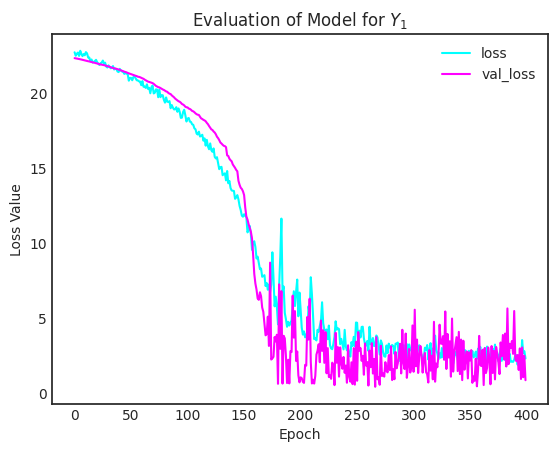

In [ ]:
#@title ##### Plot of $Y_1$ Model Evaluation

with mpl.style.context("seaborn-v0_8-white", after_reset= True):
    historyY1.plot(
        xlabel= "Epoch", ylabel= "Loss Value",
        cmap= "cool",
        title= r"Evaluation of Model for $Y_1$"
        );

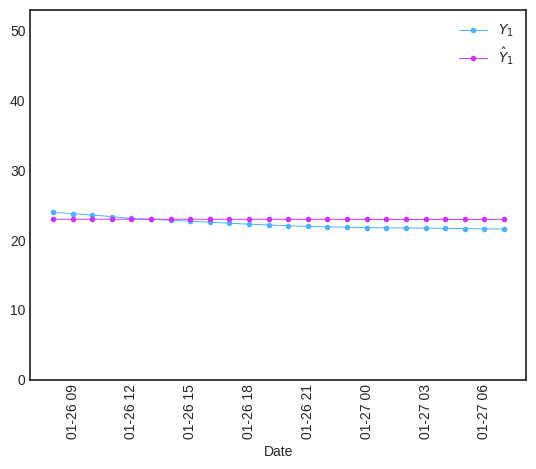

In [ ]:
#@title ##### Prediction Evaluation of the model for $Y_1$

evaluate_model(
    train_test_Y1[1], "Y1",
    modelY1, scalerY1, historyY1,
    labels= [r"$Y_1$", r"$\hat{Y}_1$"],
    lstm= True,
    ylim= (min(sa_df["pm25"].min(), 0), sa_df["pm25"].max())
    )

### **4.2. Model for $Y_2$**

In [ ]:
#@title ##### Model for $Y_2$

train_test_Y2 = train_valid_set(
    "Y2", day= False,  modulo= True, hour= False,
    lags= [25]
)

# modelY2, scalerY2, historyY2 = ann_model(
#     *train_test_Y2, "Y2",
#     lstm= False, first_units= 200,
#     num_hidden_layers= 7, hidden_units= 200,
#     batch_size= train_test_Y1[0].shape[0],
#     dropout= 0.35,
#     start_from_epoch= 10, epochs= 1500, patience= 1490
#     )
modelY2, scalerY2, historyY2 = ann_model(
    *train_test_Y2, "Y2",
    lstm= False, first_units= 300,
    num_hidden_layers= 17, hidden_units= 300,
    # batch_size= train_test_Y1[0].shape[0],
    batch_size= 16,
    dropout= 0.35, start_from_epoch= 10,
    # epochs= 400, patience= 390
    epochs= 600, patience= 590
    )

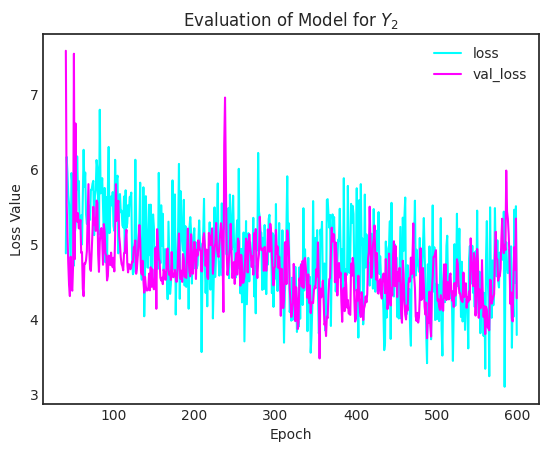

In [ ]:
#@title ##### Plot of $Y_2$ Model Evaluation

with mpl.style.context("seaborn-v0_8-white", after_reset= True):
    historyY2[(historyY2)["val_loss"] < 8].plot(
        xlabel= "Epoch", ylabel= "Loss Value",
        cmap= "cool",
        title= r"Evaluation of Model for $Y_2$"
        );

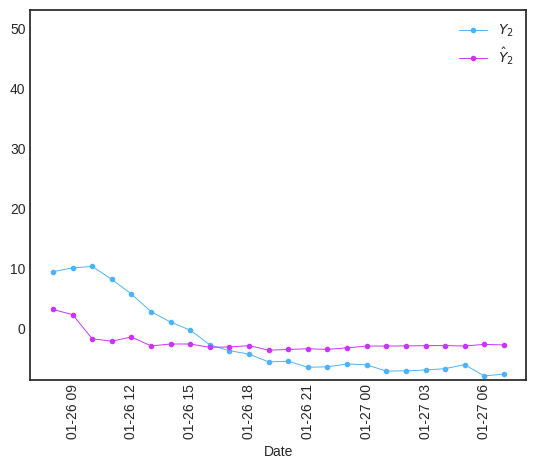

In [ ]:
#@title ##### Prediction Evaluation of the model for $Y_2$

evaluate_model(
    train_test_Y2[1], "Y2",
    modelY2, scalerY2, historyY2,
    labels= [r"$Y_2$", r"$\hat{Y}_2$"],
    lstm= False,
    ylim= (sa_df["appx_Y2"].min(), sa_df["pm25"].max())
    )

### **4.3. Model for $Y_3$**

In [ ]:
#@title ##### Model for $Y_3$

train_test_Y3 = train_valid_set(
    "Y3", day= False,  modulo= True, hour= False,
    lags= None
)

modelY3, scalerY3, historyY3 = ann_model(
    *train_test_Y3, "Y3",
    lstm= False, first_units= 200,
    num_hidden_layers= 17, hidden_units= 200,
    start_from_epoch= 0, epochs= 1000, patience= 1000,
    dropout= 0.4,
    batch_size= 16,
    min_delta= 0.0001,
    )

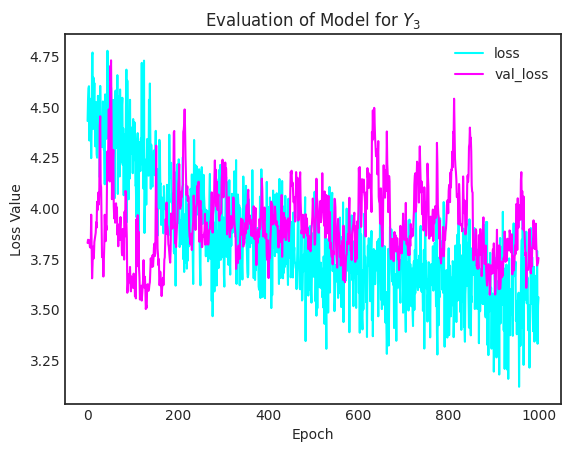

In [ ]:
#@title ##### Plot of $Y_3$ Model Evaluation

with mpl.style.context("seaborn-v0_8-white", after_reset= True):
    historyY3.plot(
        xlabel= "Epoch", ylabel= "Loss Value",
        cmap= "cool",
        title= r"Evaluation of Model for $Y_3$"
        );

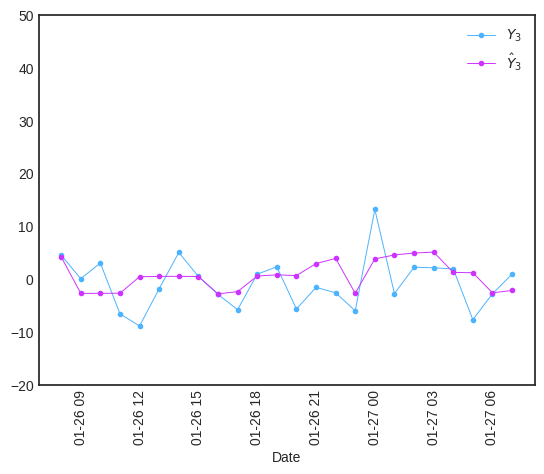

In [ ]:
#@title ##### Evaluating the model for $Y_3$

evaluate_model(
    train_test_Y3[1], "Y3",
    modelY3, scalerY3, historyY3,
    labels= [r"$Y_3$", r"$\hat{Y}_3$"],
    lstm= False,
    ylim= (-20, 50)
    )

In [ ]:
#@title ### **Saving the Models and Scalers**

import joblib

save_path = "/content/drive/MyDrive/Pretrained ANN Model/South Jakarta Air Quality Project/"

# # Model of Y1:
# modelY1.save(save_path + "modelY1.keras")
# joblib.dump(scalerY1, save_path + "scalerY1.joblib")
# historyY1.to_csv(save_path + "historyY1.csv")

# # Model of Y2:
# modelY2.save(save_path + "modelY2.keras")
# joblib.dump(scalerY2, save_path + "scalerY2.joblib")
# historyY2.to_csv(save_path + "historyY2.csv")

# # Model of Y3:
# modelY3.save(save_path + "modelY3.keras")
# joblib.dump(scalerY3, save_path + "scalerY3.joblib")
# historyY3.to_csv(save_path + "historyY3.csv")

## **5. Forecasting**

As we have built the machine learning model for forecasting in section 4, we will use the model to perform a 24 hours forecasting. The computation is conducted in the following cell:

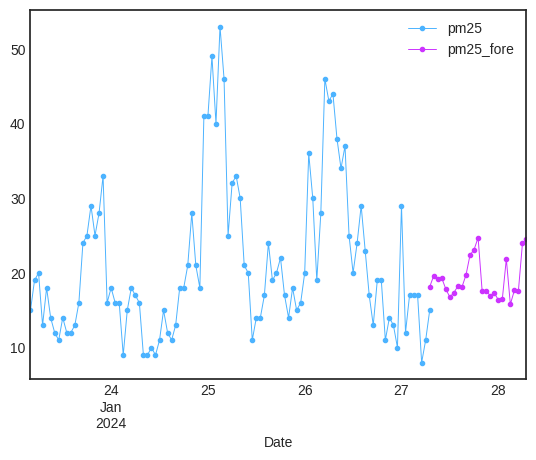

In [ ]:
#@title ##### A 24 Hours Forecasting

# Date of forecast:
date_fore = pd.date_range(
        start= list(sa_df["Date"])[-1],
        periods= 25,
        freq= "h"
    )

# Forecasting Y1:
def forecast_Y1(lags, verbose= 0):
    lag_df = ats.lag_fore_horizon(
        lags, sa_df["Y1"]
    )
    day = pd.Series([int(str(d.date())[-2:]) for d in date_fore])
    day.index = list(lag_df.index)
    df = pd.concat([day, lag_df], axis= 1)
    df.columns = ["day"] + list(lag_df.columns)

    X_fore = scalerY1.transform(df)
    X_fore = X_fore.reshape(X_fore.shape[0], 1, X_fore.shape[1])

    y_fore = np.array(
        [y[0] for y in modelY1.predict(X_fore, verbose= verbose)]
    )

    return y_fore


# Forecasting Y2:
def forecast_Y2(lags, verbose= 0):
    lag_df = ats.lag_fore_horizon(
        lags, sa_df["appx_Y2"]
    )
    lag_df = lag_df.loc[lag_df.index[:-1], :].copy()
    mod_corr = mod_corr_Y2[(mod_corr_Y2["corr"] >= modulo_threshold)]
    mod_dict = dict()
    for m in mod_corr["mod"]:
        mod_dict[f"X{m}"] = [i % m for i in lag_df.index]
    mod_df = pd.DataFrame(mod_dict, index= lag_df.index)
    df = pd.concat([mod_df, lag_df], axis= 1)

    X_fore = pd.DataFrame(
        scalerY2.transform(df),
        columns= df.columns
    )

    y_fore = np.array(
        [y[0] for y in modelY2.predict(X_fore, verbose= verbose)]
    )

    return y_fore

# Forecasting Y3:
def forecast_Y3(verbose= 0):
    index = [sa_df.index[-1] + k for k in range(25)]
    mod_corr = mod_corr_Y3[(mod_corr_Y3["corr"] >= modulo_threshold)]
    mod_dict = dict()
    for m in mod_corr["mod"]:
        mod_dict[f"X{m}"] = [i % m for i in index]
    df = pd.DataFrame(mod_dict, index= index)

    X_fore = pd.DataFrame(
        scalerY3.transform(df),
        columns= df.columns
    )

    y_fore = np.array(
        [y[0] for y in modelY3.predict(X_fore, verbose= verbose)]
    )

    return y_fore

# Total Forecasting:
jaksel_fore = pd.DataFrame(
    {
        "Date": date_fore,
        "pm25_fore": forecast_Y1([24, 25]) + forecast_Y2([25]) + forecast_Y3()
    },
    index= [sa_df.index[-1] + k for k in range(25)]
)

# Displaying the forecast:
with mpl.style.context("seaborn-v0_8-white", after_reset= True):
    fore_fig, fore_ax = plt.subplots(nrows= 1, ncols= 1)
    fore_fig = jaksel_df.set_index("Date").plot(
        color= plt.cm.cool(0.3),
        label= r"$Y$", legend= True,
        marker= ".", linewidth= 0.7,
        ax= fore_ax
        )
    fore_fig = jaksel_fore.set_index("Date").plot(
        color= plt.cm.cool(0.8),
        label= r"$\hat{Y}$", legend= True,
        marker= ".", linewidth= 0.7,
        ax= fore_ax
        )
    fore_fig = plt.show()